In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cnfg
import re
import os
from sqlalchemy import create_engine
from gensim import corpora, models, similarities, matutils
from sklearn.preprocessing import Normalizer, normalize
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters
from gensim.models import word2vec
from gensim import models
from collections import defaultdict
from sklearn.manifold import TSNE
import nltk

import logging
from sklearn.decomposition import TruncatedSVD, NMF

# logging for gensim (set to INFO)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%matplotlib inline

In [2]:
config = cnfg.load(".metis_config")
engine = create_engine('postgresql://{}:{}@{}:5432/{}'.format(
                        config['db_user'],
                        config['db_pwd'],
                        config['db_host'],
                        'sephora'))

query_product = """SELECT * FROM sephora_product WHERE category IN ('moisturizers', 'face serums', 'face wash & cleansers',
         'eye creams & treatments', 'face masks', 'moisturizer & treatments',
         'face oils')"""
df_product = pd.read_sql_query(query_product, engine)
# df_product = pd.read_csv('data/sephora_product.csv')
df_product = df_product.set_index('id')
df_product.head(3)

,product_url,sku,category,brand,name,rating,detail_text,size_oz,price
id,,,,,,,,,
P102503,/wrinkle-revenge-rescue-protect-facial-cream-P...,844480,moisturizers,DERMAdoctor,Wrinkle Revenge Rescue & Protect Facial Cream,4.2366,What it is:A lightweight concentrate that deli...,1.7,57
P102504,/wrinkle-revenge-eye-balm-P102504,844472,eye creams & treatments,DERMAdoctor,Wrinkle Revenge Eye Balm,4.0591,What it is:A super-hydrating eye balm enriched...,0.5,50
P107306,/renewing-eye-cream-P107306,769836,eye creams & treatments,Murad,Renewing Eye Cream,4.0706,"What it is: A multiactive, antiaging treatment...",0.5,80


In [3]:
query_review = 'SELECT * FROM sephora_product_review'
df = pd.read_sql_query(query_review, engine)
# df = pd.read_csv('data/sephora_review.csv')
# df = df[df.rating <= 3]
df.head()

,product_id,review_title,review_text,rating,age_range,skin_type,skin_tone,eye_color,reviewer_username,tags,review_id
0,P402714,Hydra-Therapy Memory Sleep Mask,This is the best moisture for the skin. Since ...,5,None,None,None,None,Francam915,None,cdfff97a-0d7e-420f-86c4-395b0a400487
1,P402714,IMPRESSIVE!,This is quite possibly magic in a bottle. I wa...,5,None,None,None,None,AVZ715,None,f42b8d0c-8f24-42d7-b426-90ccbba64741
2,P402714,the very best I've ever used!,I've tried all kinds of sleeping masks to cont...,5,None,None,None,None,Anonymous,None,51e2335c-952f-486a-8488-dca335b213d4
3,P402714,chemicals!!!,Don't waste your money. Look how much dimethic...,1,None,None,None,None,LNM87,None,838d4d84-e66b-4e46-9bcc-c868c6170253
4,P402714,best mask,Literally have no idea why more people don't t...,5,None,None,None,None,dollie72,None,f3c4df71-5194-4a15-860d-5cee51c53931


In [4]:
# df = df.set_index('review_id')

# Split review_text into sentences
punkt_param = PunktParameters()
punkt_param.abbrev_types = set(['dr', 'vs', 'mr', 'mrs'])
tokenizer = PunktSentenceTokenizer(punkt_param)
tokenizer.tokenize('Dr. Smith is a doctor. He is the best ... not')

['Dr. Smith is a doctor.', 'He is the best ... not']

In [5]:
df['review_sentences'] = df['review_text'].map(lambda text: tokenizer.tokenize(text))

In [6]:
sample_review_index = 3
print(df.iloc[sample_review_index]['review_text'])
df.iloc[sample_review_index]['review_sentences']

Don't waste your money. Look how much dimethicone is in it. Your skin feels great because of this harsh fake chemical!


["Don't waste your money.",
 'Look how much dimethicone is in it.',
 'Your skin feels great because of this harsh fake chemical!']

In [7]:
def split_long_sentence(sentences):
    shorter_sentences = []
    for sentence in sentences:
        if len(sentence) >= 50:
            sub_sentences = re.split('&|!|;|and|,|~|but|\.|so i|\s-\s|\(|\)', sentence.lower())
            sub_sentences = [s.strip() for s in sub_sentences]
            shorter_sentences += sub_sentences
        else:
            shorter_sentences.append(sentence.lower())
    shorter_sentences = filter(lambda s: len(s) > 13 
                               and not s.startswith('i have')
                               and not s.startswith('i also have')
                               and not s.startswith('i\'m')
                               and not s.startswith('i had')
                               and not s.startswith('i\'ve been')
                               and not s.startswith('i thought')
                               and not s.startswith('i was ')
                               and not s.startswith('i use ')
                               and not s.startswith('i used to')
                               and not s.startswith('if you have')
                               and not s.startswith('i suffer')
                               and not ('i do have' in s)
                               and not ('looking for' in s)
                               and not ('i purchase' in s)
                               and not ('i bought' in s)
                               , shorter_sentences)
    return list(shorter_sentences)

split_long_sentence([
    "I have mild acne",
    "i do have to comment on the packaging because it is as terrible as everyone says it is"
    "Totally I was on the lookout for a long time fora great moisturizer",
    "At first it took a few times to figure out the best way to wrap the magnet (if you don't it's almost impossible to get the product off) then this is great",
    "It absorbs fairly quick - 3-5 minutes depending on how much serum you use.",
    "It's too oily to use as an eye-makeup remover and the scent is over powering, the dispenser does not work well", 
    "It'll leave this oily film over your eye balls and cloud your vision until your eye does its job but coughs the film back out in the form of an eye booger...so maybe not",
    "almost can feel like it is burning sometimes so I have to use this on nights I am not doing anything other than washing my face."])

['at first it took a few times to figure out the best way to wrap the magnet',
 "if you don't it's almost impossible to get the product off",
 'then this is great',
 'it absorbs fairly quick',
 '3-5 minutes depending on how much serum you use',
 "it's too oily to use as an eye-makeup remover",
 'the scent is over powering',
 'the dispenser does not work well',
 "it'll leave this oily film over your eye balls",
 'cloud your vision until your eye does its job',
 'coughs the film back out in the form of an eye booger',
 'almost can feel like it is burning sometimes',
 'have to use this on nights i am not doing anything other than washing my face']

In [8]:
# Build a new dataframe with each sentence as a document
review_ids = []
review_sentences = []
for review in df.as_matrix():
    curr_review_id = review[-2]
    curr_review_sentences = review[-1]
    
    # Divide long sentences even longer if possible!
    shorter_sentences = split_long_sentence(curr_review_sentences)
    
    review_ids += [curr_review_id] * len(shorter_sentences)
    review_sentences += shorter_sentences
    
df_review_sentences = pd.DataFrame({'review_id': review_ids, 'sentence': review_sentences})
df_review_sentences.head()

,review_id,sentence
0,cdfff97a-0d7e-420f-86c4-395b0a400487,this is the best moisture for the skin.
1,cdfff97a-0d7e-420f-86c4-395b0a400487,since i have been using it my skin looks 10 ye...
2,cdfff97a-0d7e-420f-86c4-395b0a400487,the product makes my skin super soft
3,cdfff97a-0d7e-420f-86c4-395b0a400487,very hydrating
4,cdfff97a-0d7e-420f-86c4-395b0a400487,not greasy at all


In [9]:
df_review_sentences.shape

(744390, 2)

## Tokenizer

In [10]:
# Get stop words
stop_words = set(open('data/stopwords_v2.txt').read().split())

In [11]:
tokenizer_regex = re.compile(r"[\s]")

def tokenize(text):
    clean_text = re.sub(r'[,!.$\d%&~?()#<>"=/-]', ' ', text)
    clean_text = ' '.join(clean_text.split())
    tokens = [tok.strip().lower() for tok in tokenizer_regex.split(clean_text)]
    filtered_tokens = tokens# filter(lambda tok: tok not in stop_words, tokens)
    return list(filtered_tokens)

In [12]:
tokenize('skin abc & def<')

['skin', 'abc', 'def']

## TF-IDF

In [13]:
def get_word_weights(docs):
    tfidf = TfidfVectorizer(stop_words=frozenset(), 
                            tokenizer=tokenize,
                            ngram_range=(1,1))
    tfidf.fit(docs)
    max_idf = max(tfidf.idf_)
    word2weight = defaultdict(lambda: max_idf,
                                    [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    return word2weight
    
test_docs2 = ["dog cat fish","dog cat cat","fish bird", 'bird fish. bird', 'blah cat', 'tata harper']
get_word_weights(test_docs2)

defaultdict(<function __main__.get_word_weights.<locals>.<lambda>>,
            {'bird': 1.8472978603872037,
             'blah': 2.2527629684953681,
             'cat': 1.5596157879354227,
             'dog': 1.8472978603872037,
             'fish': 1.5596157879354227,
             'harper': 2.2527629684953681,
             'tata': 2.2527629684953681})

## Word2Vec

In [14]:
w2v = models.KeyedVectors.load_word2vec_format("../GoogleNews-vectors-negative300.bin",binary=True)

2017-08-24 15:02:24,772 : INFO : loading projection weights from ../GoogleNews-vectors-negative300.bin
2017-08-24 15:03:37,883 : INFO : loaded (3000000, 300) matrix from ../GoogleNews-vectors-negative300.bin


In [15]:
# np.mean(w2v[['it\'s', 'is', 'moisturizer', 'reviews']], axis=0)
# w2v['wrinkle']

In [16]:
w2v.most_similar(positive=['wrinkle'], topn=25)

2017-08-24 15:03:37,894 : INFO : precomputing L2-norms of word weight vectors


[('wrinkles', 0.6509594917297363),
 ('twist', 0.5201830863952637),
 ('cellulite', 0.4519196152687073),
 ('wrinkle_remover', 0.4473875164985657),
 ('kink', 0.43007057905197144),
 ('creases', 0.4271658658981323),
 ('Botox', 0.42587846517562866),
 ('wrinkle_reducer', 0.42533019185066223),
 ("crow's_feet", 0.42372927069664),
 ('wrinkle_filler', 0.42249032855033875),
 ('Prevage', 0.4219375550746918),
 ('dimension', 0.41997307538986206),
 ('volumizing', 0.41956183314323425),
 ('Frownies', 0.4190055727958679),
 ('slenderizing', 0.41443490982055664),
 ('eye_makeup_remover', 0.41385316848754883),
 ('stimulates_collagen_production', 0.41349709033966064),
 ('aging_creams', 0.41251763701438904),
 ('cellulite_creams', 0.41042596101760864),
 ('exfoliant', 0.40742120146751404),
 ('facial_creases', 0.4038386642932892),
 ('aging_serums', 0.40091755986213684),
 ('Sculptra', 0.40089690685272217),
 ('translucent_powder', 0.40067803859710693),
 ('self_tanner', 0.4004167914390564)]

In [17]:
'review' in w2v.vocab

True

In [18]:
df_review_sentences['tokenized_words'] = df_review_sentences['sentence'].map(lambda sentence: tokenize(sentence))
df_review_sentences['tokenized_filtered_words'] = df_review_sentences['tokenized_words'].map(
    lambda tokenized_words: [word for word in tokenized_words if word in w2v.vocab])
df_review_sentences['tokenized_filtered_words_length'] = df_review_sentences['tokenized_filtered_words'].map(
    lambda tokenized_filtered_words: len(tokenized_filtered_words))

In [19]:
# Remove sentences that less than 4 words
df_review_sentences = df_review_sentences[df_review_sentences.tokenized_filtered_words_length > 3]
df_review_sentences = df_review_sentences.reset_index()
word2weight = get_word_weights(df_review_sentences['sentence'])
# word2weight={}

## Parts of Speech & Count Vectorizer

In [20]:
def get_docs_vocab(docs):
    count_vectorizer = CountVectorizer(ngram_range=(1,1),  
                                       stop_words=frozenset(), 
                                       tokenizer=tokenize)
    count_vectorizer.fit_transform(docs)
    vocab = count_vectorizer.vocabulary_.keys()
    return vocab
get_docs_vocab(['cat mouse dog', 'mouse dog'])

dict_keys(['cat', 'mouse', 'dog'])

In [21]:
# Use parts of speech
def get_pos_weight(tokens):
    word_pos = nltk.pos_tag(tokens)
    word_to_weight = {}
    for word, pos in word_pos:
        if pos.startswith('JJ') | pos.startswith('RB'):
            word_to_weight[word] = 2 # adjective or adverb
        elif (pos == 'VBD') | (pos == 'VBG') | (pos == 'VBN'):
            word_to_weight[word] = 1.3 # verb
#         elif (pos == 'NN'):
#             word_to_weight[word] = 1.1 # noun
        else: 
            word_to_weight[word] = 1
    return word_to_weight
    
  

In [22]:
test_pos = defaultdict( list )
test_words = ['refreshed', 'tingling', 'tried', 'redness', 'dried', 'dry', 'added',
              'eczema', 'sensitive', 'tight', 'recommend', 'pick', 'matte', 'removed', 'slippery',
              'irritated', 'pleased', 'feels', 'five', 'forever', 'milky', 'hydrated', 'favorite', 'didn\'t']
test_words_pos = nltk.pos_tag(test_words)
for word, pos in test_words_pos:
    test_pos[pos].append(word)
#get_pos_weight(test_words)
test_pos

defaultdict(list,
            {'CD': ['five'],
             'JJ': ['tried',
              'dry',
              'sensitive',
              'tight',
              'pleased',
              'favorite'],
             'NN': ['redness', 'recommend', 'pick', 'matte', "didn't"],
             'NNS': ['feels'],
             'RB': ['eczema', 'slippery', 'forever', 'milky'],
             'VBD': ['dried', 'added', 'removed'],
             'VBG': ['tingling'],
             'VBN': ['refreshed', 'irritated', 'hydrated']})

In [23]:
docs_vocab = get_docs_vocab(df_review_sentences['sentence'])
pos_weights = get_pos_weight(docs_vocab)

In [24]:
def word2vec_pos_weight(tokenized_filtered_words):
    return np.mean([w2v[w] * pos_weights.get(w, 1) * word2weight[w]
             for w in tokenized_filtered_words], axis=0)

In [25]:
# For each sentence, find word2vec vector
# np.mean(w2v[['it\'s', 'is', 'moisturizer', 'reviews']], axis=0)
def word2vec_tfidf(tokenized_filtered_words):
    return np.mean([w2v[w] * word2weight[w]
             for w in tokenized_filtered_words], axis=0)

# word2vec_tfidf(['apple', 'banana']).shape

In [26]:
df_review_sentences['word2vec'] = df_review_sentences['tokenized_filtered_words'].map(
    # lambda tokenized_filtered_words: np.mean(w2v[tokenized_filtered_words], axis=0)
    # lambda tokenized_filtered_words: word2vec_tfidf(tokenized_filtered_words)
    lambda tokenized_filtered_words: word2vec_pos_weight(tokenized_filtered_words)
)
df_review_sentences.head()

,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec
0,0,cdfff97a-0d7e-420f-86c4-395b0a400487,this is the best moisture for the skin.,"[this, is, the, best, moisture, for, the, skin]","[this, is, the, best, moisture, for, the, skin]",8,"[-0.140483, 0.267642, 0.383836, -0.122007, 0.1..."
1,1,cdfff97a-0d7e-420f-86c4-395b0a400487,since i have been using it my skin looks 10 ye...,"[since, i, have, been, using, it, my, skin, lo...","[since, i, have, been, using, it, my, skin, lo...",11,"[0.086045, 0.431334, -0.0138458, 0.103999, -0...."
2,2,cdfff97a-0d7e-420f-86c4-395b0a400487,the product makes my skin super soft,"[the, product, makes, my, skin, super, soft]","[the, product, makes, my, skin, super, soft]",7,"[0.299324, 0.678529, 0.454863, 0.461482, -0.52..."
3,4,cdfff97a-0d7e-420f-86c4-395b0a400487,not greasy at all,"[not, greasy, at, all]","[not, greasy, at, all]",4,"[-0.0992166, -0.144592, 0.212095, 0.652523, -0..."
4,5,cdfff97a-0d7e-420f-86c4-395b0a400487,it seeps into the skin very quickly,"[it, seeps, into, the, skin, very, quickly]","[it, seeps, into, the, skin, very, quickly]",7,"[0.251653, 0.415957, -0.36786, 0.237884, -1.18..."


In [27]:
# pd.DataFrame(df_review_sentences['word2vec'].values.tolist())

In [28]:
sentence_word_vectors = np.array(df_review_sentences['word2vec'].values.tolist())

## Clustering Functions

In [29]:
def plot_kmeans_inertia(data):
    """Figure out optimized number of clusters for KMeans"""
    max_number_clusters = 20
    inertia_values = []
    for cluster_count in range(1, max_number_clusters+1):
        print('fitting cluster ', cluster_count)
        km = KMeans(n_clusters=cluster_count)
        km.fit(data)
        inertia_values.append(km.inertia_)

    plt.plot(range(1, max_number_clusters+1), inertia_values)

## Aglomerative Clustering

## K-Means

In [30]:
sentence_word_vectors.shape

(655588, 300)

In [31]:
cluster_count = 30
number_sentences = sentence_word_vectors.shape[0]
df_review_sentences_truncated = df_review_sentences.iloc[0:number_sentences, :]
sentence_word_vectors_truncated = sentence_word_vectors[0:number_sentences, :]
sentence_word_vectors_truncated = normalize(sentence_word_vectors_truncated)
sentence_word_vectors_truncated.shape

(655588, 300)

In [32]:
km = MiniBatchKMeans(n_clusters=cluster_count)
review_word2vec_clusters = km.fit_predict(sentence_word_vectors_truncated)
len(review_word2vec_clusters)

655588

In [33]:
# Create vector of sentence to cluster number
df_sentence_cluster = pd.DataFrame({})
cluster_columns = ['feat_' + str(i) for i in range(0, cluster_count)]
for i in range(0, cluster_count):
    cluster_column = cluster_columns[i]
    df_sentence_cluster[cluster_column] = (review_word2vec_clusters == i).astype(int)
    
df_sentence = pd.concat([df_review_sentences, df_sentence_cluster], axis=1)
df_sentence[df_sentence['feat_0'] == 1].head()

,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec,feat_0,feat_1,feat_2,...,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29
56,62,7e85aad8-8ad0-47b8-be83-31f02b0d1b39,my foundation now last.,"[my, foundation, now, last]","[my, foundation, now, last]",4,"[0.570175, 0.187822, 0.220772, 0.316093, 0.164...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
64,71,5bdf38f7-4ede-40cc-a892-e652b572cfe2,it's been about 4 months,"[it's, been, about, months]","[it's, been, about, months]",4,"[0.187652, 0.0223328, 0.292947, 0.517692, -1.0...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
76,83,78577013-0e5b-436e-ab66-3176be368ddf,plus the deluxe sample bar has lasted me a ver...,"[plus, the, deluxe, sample, bar, has, lasted, ...","[plus, the, deluxe, sample, bar, has, lasted, ...",17,"[-0.172708, 0.136284, -0.32201, 0.660491, 0.02...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
90,99,f12aa796-e7ab-472c-91c8-290af43acaf0,laszlo was probably the 'father' of double cle...,"[laszlo, was, probably, the, 'father', of, dou...","[was, probably, the, double, cleansing, decade...",7,"[-0.210991, 0.665522, 0.365352, 1.26234, -0.44...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
111,123,440d4fb4-c619-423e-975a-8e988968664b,been using it for the past couple of weeks,"[been, using, it, for, the, past, couple, of, ...","[been, using, it, for, the, past, couple, weeks]",8,"[0.0335324, 0.298263, -0.500773, 0.199006, 0.0...",1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Merging Review Sentences with Products

In [34]:
df_sentence_product = pd.merge(df_sentence, df, on='review_id', how='left')
df_sentence_product.head()

,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec,feat_0,feat_1,feat_2,...,review_title,review_text,rating,age_range,skin_type,skin_tone,eye_color,reviewer_username,tags,review_sentences
0,0,cdfff97a-0d7e-420f-86c4-395b0a400487,this is the best moisture for the skin.,"[this, is, the, best, moisture, for, the, skin]","[this, is, the, best, moisture, for, the, skin]",8,"[-0.140483, 0.267642, 0.383836, -0.122007, 0.1...",0,0,0,...,Hydra-Therapy Memory Sleep Mask,This is the best moisture for the skin. Since ...,5,None,None,None,None,Francam915,None,"[This is the best moisture for the skin., Sinc..."
1,1,cdfff97a-0d7e-420f-86c4-395b0a400487,since i have been using it my skin looks 10 ye...,"[since, i, have, been, using, it, my, skin, lo...","[since, i, have, been, using, it, my, skin, lo...",11,"[0.086045, 0.431334, -0.0138458, 0.103999, -0....",0,0,0,...,Hydra-Therapy Memory Sleep Mask,This is the best moisture for the skin. Since ...,5,None,None,None,None,Francam915,None,"[This is the best moisture for the skin., Sinc..."
2,2,cdfff97a-0d7e-420f-86c4-395b0a400487,the product makes my skin super soft,"[the, product, makes, my, skin, super, soft]","[the, product, makes, my, skin, super, soft]",7,"[0.299324, 0.678529, 0.454863, 0.461482, -0.52...",0,0,0,...,Hydra-Therapy Memory Sleep Mask,This is the best moisture for the skin. Since ...,5,None,None,None,None,Francam915,None,"[This is the best moisture for the skin., Sinc..."
3,4,cdfff97a-0d7e-420f-86c4-395b0a400487,not greasy at all,"[not, greasy, at, all]","[not, greasy, at, all]",4,"[-0.0992166, -0.144592, 0.212095, 0.652523, -0...",0,0,0,...,Hydra-Therapy Memory Sleep Mask,This is the best moisture for the skin. Since ...,5,None,None,None,None,Francam915,None,"[This is the best moisture for the skin., Sinc..."
4,5,cdfff97a-0d7e-420f-86c4-395b0a400487,it seeps into the skin very quickly,"[it, seeps, into, the, skin, very, quickly]","[it, seeps, into, the, skin, very, quickly]",7,"[0.251653, 0.415957, -0.36786, 0.237884, -1.18...",0,0,0,...,Hydra-Therapy Memory Sleep Mask,This is the best moisture for the skin. Since ...,5,None,None,None,None,Francam915,None,"[This is the best moisture for the skin., Sinc..."


In [35]:
# Split dataframe into two dataframes, one with positive sentences, another with negative sentences
# Positive sentences:
df_sentence_product_pos = df_sentence_product[df_sentence_product.rating > 3]
df_sentence_product_neg = df_sentence_product[df_sentence_product.rating <= 3]

# Rename features in df_sentence_product_neg
neg_feature_columns = ['neg_' + col_name for col_name in cluster_columns]
# df.rename(columns={'Leader': 'Commander'}, inplace=True)
df_sentence_product_neg.rename(columns=dict(zip(cluster_columns, neg_feature_columns)), inplace=True)
df_sentence_product_neg.head()


/Users/nanawu/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/frame.py:2844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec,neg_feat_0,neg_feat_1,neg_feat_2,...,review_title,review_text,rating,age_range,skin_type,skin_tone,eye_color,reviewer_username,tags,review_sentences
20,23,838d4d84-e66b-4e46-9bcc-c868c6170253,don't waste your money.,"[don't, waste, your, money]","[don't, waste, your, money]",4,"[0.58666, 1.00408, 1.22174, 1.66089, -1.29472,...",0,0,0,...,chemicals!!!,Don't waste your money. Look how much dimethic...,1,None,None,None,None,LNM87,None,"[Don't waste your money., Look how much dimeth..."
21,24,838d4d84-e66b-4e46-9bcc-c868c6170253,look how much dimethicone is in it.,"[look, how, much, dimethicone, is, in, it]","[look, how, much, dimethicone, is, in, it]",7,"[0.199433, 0.354757, 0.291387, 0.466015, -0.37...",0,0,0,...,chemicals!!!,Don't waste your money. Look how much dimethic...,1,None,None,None,None,LNM87,None,"[Don't waste your money., Look how much dimeth..."
22,25,838d4d84-e66b-4e46-9bcc-c868c6170253,your skin feels great because of this harsh fa...,"[your, skin, feels, great, because, of, this, ...","[your, skin, feels, great, because, this, hars...",9,"[0.537647, 0.953709, 0.368976, -0.0322699, -0....",0,0,0,...,chemicals!!!,Don't waste your money. Look how much dimethic...,1,None,None,None,None,LNM87,None,"[Don't waste your money., Look how much dimeth..."
36,41,7ae62b14-dc9b-4961-8d59-c460190943ac,really not a big fan of erno laszlo.,"[really, not, a, big, fan, of, erno, laszlo]","[really, not, big, fan]",4,"[1.29332, 0.603295, -0.0486568, 1.11054, -0.21...",0,0,0,...,Not A Big Fan,Really not a big fan of Erno Laszlo. I switche...,3,None,None,None,None,Celesty,None,"[Really not a big fan of Erno Laszlo., I switc..."
37,42,7ae62b14-dc9b-4961-8d59-c460190943ac,i switched to this product from the detox sets...,"[i, switched, to, this, product, from, the, de...","[i, switched, this, product, from, the, detox,...",15,"[-0.496783, 0.612659, -0.212059, 0.439267, -0....",0,0,0,...,Not A Big Fan,Really not a big fan of Erno Laszlo. I switche...,3,None,None,None,None,Celesty,None,"[Really not a big fan of Erno Laszlo., I switc..."


In [36]:
# Stack positive and negative dataframes on top of each other
df_sentence_product_pos_neg = pd.concat([df_sentence_product_pos, df_sentence_product_neg])
df_sentence_product_pos_neg = df_sentence_product_pos_neg.fillna(0)
df_sentence_product_pos_neg = df_sentence_product_pos_neg.reset_index()

In [37]:
# df_sentence_product_pos_neg.iloc[-4][neg_feature_columns + ['sentence']]
df_sentence_product_pos_neg.head()

,level_0,age_range,eye_color,feat_0,feat_1,feat_10,feat_11,feat_12,feat_13,feat_14,...,review_title,reviewer_username,sentence,skin_tone,skin_type,tags,tokenized_filtered_words,tokenized_filtered_words_length,tokenized_words,word2vec
0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Hydra-Therapy Memory Sleep Mask,Francam915,this is the best moisture for the skin.,0,0,0,"[this, is, the, best, moisture, for, the, skin]",8,"[this, is, the, best, moisture, for, the, skin]","[-0.140483, 0.267642, 0.383836, -0.122007, 0.1..."
1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Hydra-Therapy Memory Sleep Mask,Francam915,since i have been using it my skin looks 10 ye...,0,0,0,"[since, i, have, been, using, it, my, skin, lo...",11,"[since, i, have, been, using, it, my, skin, lo...","[0.086045, 0.431334, -0.0138458, 0.103999, -0...."
2,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Hydra-Therapy Memory Sleep Mask,Francam915,the product makes my skin super soft,0,0,0,"[the, product, makes, my, skin, super, soft]",7,"[the, product, makes, my, skin, super, soft]","[0.299324, 0.678529, 0.454863, 0.461482, -0.52..."
3,3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Hydra-Therapy Memory Sleep Mask,Francam915,not greasy at all,0,0,0,"[not, greasy, at, all]",4,"[not, greasy, at, all]","[-0.0992166, -0.144592, 0.212095, 0.652523, -0..."
4,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Hydra-Therapy Memory Sleep Mask,Francam915,it seeps into the skin very quickly,0,0,0,"[it, seeps, into, the, skin, very, quickly]",7,"[it, seeps, into, the, skin, very, quickly]","[0.251653, 0.415957, -0.36786, 0.237884, -1.18..."


In [38]:
# Write to CSV
all_feature_columns = cluster_columns + neg_feature_columns
for feature_name in all_feature_columns:
    df_sentences_with_feature = df_sentence_product_pos_neg[df_sentence_product_pos_neg[feature_name] != 0]
    print('Cluster {} has {} sentences'.format(feature_name, df_sentences_with_feature.shape[0]))
    data_cluster_file = 'data/cluster_reviews/' + feature_name + '.txt'
    cluster_file = open(data_cluster_file, 'w') 
    for row in df_sentences_with_feature['sentence'].as_matrix():
        cluster_file.write(row + '\n')
    cluster_file.close()

Cluster feat_0 has 11652 sentences
Cluster feat_1 has 20050 sentences
Cluster feat_2 has 7924 sentences
Cluster feat_3 has 6145 sentences
Cluster feat_4 has 24930 sentences
Cluster feat_5 has 23523 sentences
Cluster feat_6 has 23671 sentences
Cluster feat_7 has 3872 sentences
Cluster feat_8 has 31978 sentences
Cluster feat_9 has 8543 sentences
Cluster feat_10 has 27989 sentences
Cluster feat_11 has 28032 sentences
Cluster feat_12 has 4953 sentences
Cluster feat_13 has 20044 sentences
Cluster feat_14 has 17590 sentences
Cluster feat_15 has 6886 sentences
Cluster feat_16 has 18395 sentences
Cluster feat_17 has 16232 sentences
Cluster feat_18 has 11295 sentences
Cluster feat_19 has 15663 sentences
Cluster feat_20 has 20882 sentences
Cluster feat_21 has 12045 sentences
Cluster feat_22 has 28884 sentences
Cluster feat_23 has 26260 sentences
Cluster feat_24 has 32317 sentences
Cluster feat_25 has 5086 sentences
Cluster feat_26 has 8659 sentences
Cluster feat_27 has 19688 sentences
Cluster fe

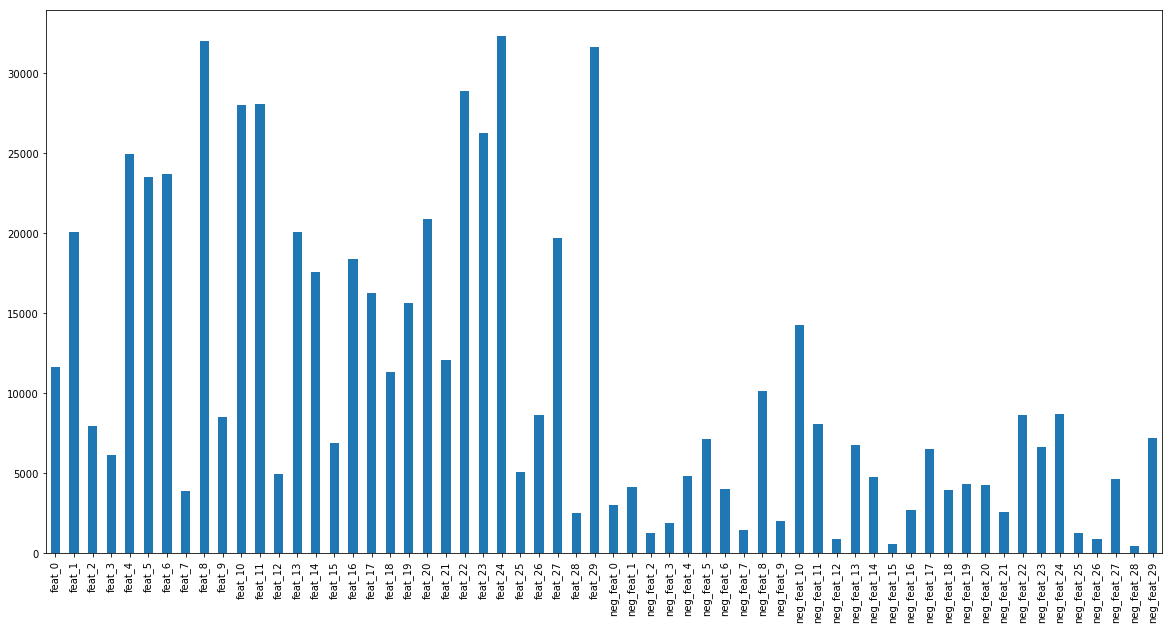

In [39]:
df_sentence_products_clusters = df_sentence_product_pos_neg[all_feature_columns + ['product_id']].groupby(['product_id']).sum()

# How many results for each feature type?
df_sentence_products_clusters.sum(axis=0).plot(kind='bar', figsize=(20,10))

In [40]:
df_sentence_products_clusters.head() # Unnormalized, Uncentered

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,neg_feat_20,neg_feat_21,neg_feat_22,neg_feat_23,neg_feat_24,neg_feat_25,neg_feat_26,neg_feat_27,neg_feat_28,neg_feat_29
product_id,,,,,,,,,,,,,,,,,,,,,
P102503,7.0,11.0,3.0,10.0,17.0,15.0,20.0,1.0,24.0,3.0,...,1.0,5.0,3.0,4.0,1.0,1.0,1.0,4.0,0.0,5.0
P102504,23.0,21.0,7.0,8.0,40.0,42.0,33.0,4.0,56.0,9.0,...,2.0,7.0,13.0,21.0,18.0,3.0,3.0,15.0,0.0,11.0
P107306,20.0,13.0,8.0,8.0,29.0,29.0,41.0,6.0,37.0,12.0,...,0.0,13.0,10.0,10.0,12.0,2.0,0.0,14.0,1.0,9.0
P112400,2.0,9.0,1.0,2.0,4.0,9.0,9.0,2.0,19.0,1.0,...,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
P113608,25.0,57.0,8.0,7.0,40.0,46.0,59.0,3.0,68.0,4.0,...,10.0,3.0,21.0,6.0,10.0,0.0,1.0,8.0,0.0,9.0


In [41]:
products_cluster_normalized = normalize(df_sentence_products_clusters) # Normalized and not Centered
df_products_cluster_normalized = pd.DataFrame(data=products_cluster_normalized, columns=all_feature_columns, index=df_sentence_products_clusters.index)
df_products_cluster_normalized.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,neg_feat_20,neg_feat_21,neg_feat_22,neg_feat_23,neg_feat_24,neg_feat_25,neg_feat_26,neg_feat_27,neg_feat_28,neg_feat_29
product_id,,,,,,,,,,,,,,,,,,,,,
P102503,0.081258,0.127691,0.034825,0.116083,0.197341,0.174125,0.232166,0.011608,0.278599,0.034825,...,0.011608,0.058042,0.034825,0.046433,0.011608,0.011608,0.011608,0.046433,0.000000,0.058042
P102504,0.122914,0.112226,0.037409,0.042753,0.213763,0.224451,0.176355,0.021376,0.299268,0.048097,...,0.010688,0.037409,0.069473,0.112226,0.096193,0.016032,0.016032,0.080161,0.000000,0.058785
P107306,0.132926,0.086402,0.053171,0.053171,0.192743,0.192743,0.272499,0.039878,0.245914,0.079756,...,0.000000,0.086402,0.066463,0.066463,0.079756,0.013293,0.000000,0.093048,0.006646,0.059817
P112400,0.048521,0.218346,0.024261,0.048521,0.097043,0.218346,0.218346,0.048521,0.460953,0.024261,...,0.000000,0.000000,0.048521,0.000000,0.048521,0.000000,0.000000,0.000000,0.000000,0.000000
P113608,0.111381,0.253949,0.035642,0.031187,0.178210,0.204941,0.262859,0.013366,0.302956,0.017821,...,0.044552,0.013366,0.093560,0.026731,0.044552,0.000000,0.004455,0.035642,0.000000,0.040097


In [42]:
# Run one time
df_products_cluster_normalized.to_csv('data/product_features.csv')

In [43]:
# Sanity check
# df_products_cluster_normalized.loc['P102503'].nlargest(5)

In [44]:
top_feature_columns = ['5th', '4th', '3rd', '2nd', '1st']
df_top_features_products = pd.DataFrame(data=products_cluster_normalized.argsort(axis = 1)[:, -5:], 
                                columns=top_feature_columns, index=df_products_cluster_normalized.index)
df_top_features_products = df_top_features_products.applymap(lambda index: all_feature_columns[index])
df_top_features_products.head()

,5th,4th,3rd,2nd,1st
product_id,,,,,
P102503,feat_10,feat_8,feat_11,feat_23,feat_29
P102504,feat_24,feat_27,feat_23,feat_8,feat_11
P107306,feat_6,feat_22,feat_10,feat_27,feat_23
P112400,feat_21,feat_22,feat_29,feat_20,feat_8
P113608,feat_22,feat_10,feat_24,feat_8,feat_20


In [45]:
dict_sentence_product_pos_neg = df_sentence_product_pos_neg.to_dict()

In [46]:
sentence_columns = ['5th_sent', '4th_sent', '3rd_sent', '2nd_sent', '1st_sent']
def get_product_sentence(row):
    product_id = row.name
    for top_feat_col in top_feature_columns:
        # print(product_id, top_feat_col, row[top_feat_col])
        feat_col = row[top_feat_col]       
        sample_sentence = ''
        indexes_for_prod = [k for k, v in dict_sentence_product_pos_neg['product_id'].items() if v == product_id]
        indexes_for_feat = [k for k in indexes_for_prod if dict_sentence_product_pos_neg[feat_col][k] > 0]
        sentences_for_feat = [dict_sentence_product_pos_neg['sentence'][k] for k in indexes_for_feat]
        if (len(sentences_for_feat) > 0):
            sample_sentence = sentences_for_feat[0]
        row[top_feat_col + '_sent'] = sample_sentence
    return row

# Sample sentences for top features for each product
df_top_features_products = df_top_features_products.apply(lambda row: get_product_sentence(row), axis=1)

In [47]:
df_top_features_products.head()

,5th,4th,3rd,2nd,1st,5th_sent,4th_sent,3rd_sent,2nd_sent,1st_sent
product_id,,,,,,,,,,
P102503,feat_10,feat_8,feat_11,feat_23,feat_29,so something in it doesn't work for me even th...,this moisturizer i had 2 small red bumps-don't...,tried all kinds of products including prescrip...,a little goes a long way,how moisturizing it is
P102504,feat_24,feat_27,feat_23,feat_8,feat_11,it dries quickly and my make up stays put.,i noticed that my eye area is much more awake,because a little goes a long way,it is not greasy or heavy.,my skin care ritual would not be completed wit...
P107306,feat_6,feat_22,feat_10,feat_27,feat_23,and it works great on those wrinkles.,i really like it as an under eye moisturizer,i don't know if this really does what it claim...,overall my eye area is brighter,my under eyes feel so much smoother
P112400,feat_21,feat_22,feat_29,feat_20,feat_8,my boyfriend has combination skin,is definitely my new go to,the description for this oil free facial lotio...,the citrus smell is also a refreshing plus,he says it doesn't make him feel more oily com...
P113608,feat_22,feat_10,feat_24,feat_8,feat_20,feel the difference on my skin for days,"it always irritates me when people say ""i trie...",rehydrated my skin so much some of my fine lin...,you can use it as a normal mask or leave it on...,this lovely mask renews


## PCA on Product Sentence Features

In [48]:
# df_products_cluster_centered = df_sentence_products_clusters - df_sentence_products_clusters.mean()
# df_products_cluster_centered.head()

In [49]:
""" 
pca = PCA(n_components=20)

# Transform X_centered to X_pca via a fit_transform
products_cluster_counts_pca = pca.fit_transform(products_cluster_normalized)
plt.bar(range(1, 21), pca.explained_variance_ratio_)
"""

' \npca = PCA(n_components=20)\n\n# Transform X_centered to X_pca via a fit_transform\nproducts_cluster_counts_pca = pca.fit_transform(products_cluster_normalized)\nplt.bar(range(1, 21), pca.explained_variance_ratio_)\n'

## Clustering Products

fitting cluster  1
fitting cluster  2
fitting cluster  3
fitting cluster  4
fitting cluster  5
fitting cluster  6
fitting cluster  7
fitting cluster  8
fitting cluster  9
fitting cluster  10
fitting cluster  11
fitting cluster  12
fitting cluster  13
fitting cluster  14
fitting cluster  15
fitting cluster  16
fitting cluster  17
fitting cluster  18
fitting cluster  19
fitting cluster  20


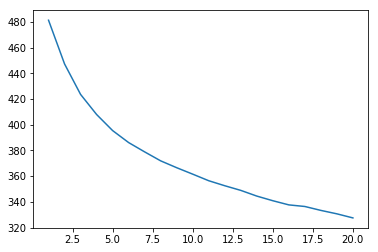

In [50]:
plot_kmeans_inertia(products_cluster_normalized)

In [51]:
product_cluster_count = 7
km = KMeans(n_clusters=product_cluster_count)
product_clusters = km.fit_predict(products_cluster_normalized)
product_ids = df_sentence_products_clusters.index

cluster_to_product_ids = {}
for product_cluster_index in range(0, product_cluster_count):
    df_product_indexes = product_ids[product_clusters == product_cluster_index]
    product_names = df_product.loc[df_product_indexes]['product_url']
    cluster_to_product_ids[product_cluster_index] = product_names
# P116609', 'P116610'    
cluster_to_product_ids

{0: product_id
 P102504                    /wrinkle-revenge-eye-balm-P102504
 P107306                          /renewing-eye-cream-P107306
 P116610    /mega-rich-intensive-anti-aging-cellular-eye-c...
 P12090                  /hope-in-a-tube-eye-lip-cream-P12090
 P122727      /repairwear-anti-gravity-eye-lift-cream-P122727
 P122774                              /all-about-eyes-P122774
 P12869               /essential-c-eye-cream-spf-15-pa-P12869
 P155113                    /wild-rose-face-eye-serum-P155113
 P158531                   /all-over-blemish-solution-P158531
 P158703    /absolue-premium-bx-absolute-night-recovery-cr...
 P158705    /absolue-premium-bx-absolute-replenishing-eye-...
 P159005                               /elixir-ancien-P159005
 P173620    /benefiance-wrinkleresist24-intensive-eye-cont...
 P173654    /bio-performance-advanced-super-revitalizer-cr...
 P174502                         /all-about-eyes-rich-P174502
 P174629               /vita-mineral-active-7-eye-gel-P

## T-SNE

In [52]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=70).fit_transform(products_cluster_normalized)


[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 1432 samples in 0.002s...
[t-SNE] Computed neighbors for 1432 samples in 0.223s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1432
[t-SNE] Computed conditional probabilities for sample 1432 / 1432
[t-SNE] Mean sigma: 0.165490
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.853302
[t-SNE] Error after 1000 iterations: 1.550722


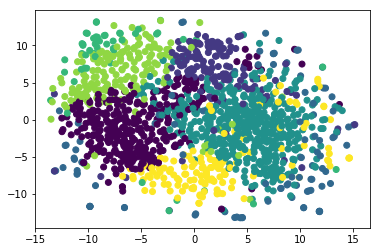

In [53]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=product_clusters)

In [54]:
df_top_features_products.head()

,5th,4th,3rd,2nd,1st,5th_sent,4th_sent,3rd_sent,2nd_sent,1st_sent
product_id,,,,,,,,,,
P102503,feat_10,feat_8,feat_11,feat_23,feat_29,so something in it doesn't work for me even th...,this moisturizer i had 2 small red bumps-don't...,tried all kinds of products including prescrip...,a little goes a long way,how moisturizing it is
P102504,feat_24,feat_27,feat_23,feat_8,feat_11,it dries quickly and my make up stays put.,i noticed that my eye area is much more awake,because a little goes a long way,it is not greasy or heavy.,my skin care ritual would not be completed wit...
P107306,feat_6,feat_22,feat_10,feat_27,feat_23,and it works great on those wrinkles.,i really like it as an under eye moisturizer,i don't know if this really does what it claim...,overall my eye area is brighter,my under eyes feel so much smoother
P112400,feat_21,feat_22,feat_29,feat_20,feat_8,my boyfriend has combination skin,is definitely my new go to,the description for this oil free facial lotio...,the citrus smell is also a refreshing plus,he says it doesn't make him feel more oily com...
P113608,feat_22,feat_10,feat_24,feat_8,feat_20,feel the difference on my skin for days,"it always irritates me when people say ""i trie...",rehydrated my skin so much some of my fine lin...,you can use it as a normal mask or leave it on...,this lovely mask renews


In [55]:
# Top 5 sentences for 
# Write to CSV
df_product_filtered = df_product.loc[df_sentence_products_clusters.index]
df_product_filtered['cluster'] = product_clusters
df_product_filtered['tsne_0'] = X_embedded[:, 0]
df_product_filtered['tsne_1'] = X_embedded[:, 1]
df_product_filtered = pd.concat([df_product_filtered, df_top_features_products], axis=1)
df_product_filtered.head()

,product_url,sku,category,brand,name,rating,detail_text,size_oz,price,cluster,...,5th,4th,3rd,2nd,1st,5th_sent,4th_sent,3rd_sent,2nd_sent,1st_sent
product_id,,,,,,,,,,,,,,,,,,,,,
P102503,/wrinkle-revenge-rescue-protect-facial-cream-P...,844480,moisturizers,DERMAdoctor,Wrinkle Revenge Rescue & Protect Facial Cream,4.2366,What it is:A lightweight concentrate that deli...,1.7,57,3,...,feat_10,feat_8,feat_11,feat_23,feat_29,so something in it doesn't work for me even th...,this moisturizer i had 2 small red bumps-don't...,tried all kinds of products including prescrip...,a little goes a long way,how moisturizing it is
P102504,/wrinkle-revenge-eye-balm-P102504,844472,eye creams & treatments,DERMAdoctor,Wrinkle Revenge Eye Balm,4.0591,What it is:A super-hydrating eye balm enriched...,0.5,50,0,...,feat_24,feat_27,feat_23,feat_8,feat_11,it dries quickly and my make up stays put.,i noticed that my eye area is much more awake,because a little goes a long way,it is not greasy or heavy.,my skin care ritual would not be completed wit...
P107306,/renewing-eye-cream-P107306,769836,eye creams & treatments,Murad,Renewing Eye Cream,4.0706,"What it is: A multiactive, antiaging treatment...",0.5,80,0,...,feat_6,feat_22,feat_10,feat_27,feat_23,and it works great on those wrinkles.,i really like it as an under eye moisturizer,i don't know if this really does what it claim...,overall my eye area is brighter,my under eyes feel so much smoother
P112400,/oil-free-facial-lotion-P112400,1605526,moisturizer & treatments,Anthony,Oil Free Facial Lotion,4.3500,"What it is:A lightweight, smoothing moisturize...",2.5,30,1,...,feat_21,feat_22,feat_29,feat_20,feat_8,my boyfriend has combination skin,is definitely my new go to,the description for this oil free facial lotio...,the citrus smell is also a refreshing plus,he says it doesn't make him feel more oily com...
P113608,/berry-nurturing-gel-mask-P113608,1910751,face masks,OLEHENRIKSEN,Berry Nurturing Gel Mask,4.4137,Which skin type is it good for? ✔ Dry ✔ Sensit...,3.2,36,3,...,feat_22,feat_10,feat_24,feat_8,feat_20,feel the difference on my skin for days,"it always irritates me when people say ""i trie...",rehydrated my skin so much some of my fine lin...,you can use it as a normal mask or leave it on...,this lovely mask renews


In [56]:
df_product_filtered.to_csv('data/tsne_product.csv')

In [57]:
max(X_embedded[:, 0])

15.163856

In [58]:
x = np.array([[1, 2, 3], [4, 5, 6]], np.int32)
normalize(x)

array([[ 0.26726124,  0.53452248,  0.80178373],
       [ 0.45584231,  0.56980288,  0.68376346]])